In [ ]:
# Step 1: Import Libraries and Initialize Constants
import os
import shutil
import glob
import copy
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

In [ ]:
# For Google Colab drive mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Constants and Configurations
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
TEMPERATURE = 5.0
LEARNING_RATE_PATIENCE = 5
EPOCHS = 50
ADVERSARIAL_EPOCHS = 20
EPSILON = 0.1
TEST_RATIO = 0.3

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Step 2: Define Models
class SimpleStudentModel(nn.Module):
    def __init__(self):
        super(SimpleStudentModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 2)

    def forward(self, x):
        return self.resnet(x)

class EnsembleModel(nn.Module):
    def __init__(self):
        super(EnsembleModel, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        self.resnet = models.resnet50(pretrained=True)
        self.efficientnet = models.efficientnet_b0(pretrained=True)

        for model in [self.densenet, self.resnet, self.efficientnet]:
            for param in model.parameters():
                param.requires_grad = False

        self.densenet.classifier = nn.Linear(self.densenet.classifier.in_features, 512)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 512)
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(self.efficientnet.classifier[1].in_features, 512)
        )

        self.weights = nn.Parameter(torch.ones(3))
        self.classifier = nn.Linear(512 * 3, 2)

    def forward(self, x):
        x1 = self.densenet(x)
        x2 = self.resnet(x)
        x3 = self.efficientnet(x)
        normalized_weights = torch.softmax(self.weights, dim=0)
        x1 = x1 * normalized_weights[0]
        x2 = x2 * normalized_weights[1]
        x3 = x3 * normalized_weights[2]
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return self.classifier(x_cat)

In [ ]:
student_model = SimpleStudentModel().to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 231MB/s]


In [ ]:
teacher_model = EnsembleModel().to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 228MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(ms

In [ ]:
# Step 3: Data Loading and Transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('/content/drive/MyDrive/BreakHis_dataset_split/train', transform=train_transforms)
validation_dataset = datasets.ImageFolder('/content/drive/MyDrive/BreakHis_dataset_split/validation', transform=test_transforms)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/BreakHis_dataset_split/test', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Visualizing dataset samples...


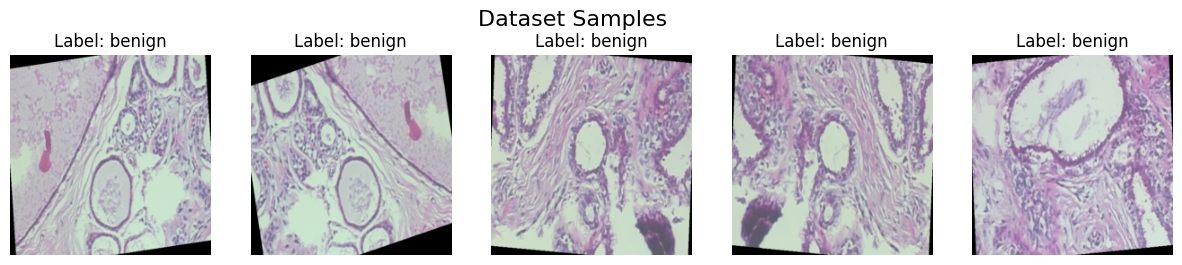

In [ ]:
# Step 4: Visualize Dataset Samples
def visualize_dataset(dataset, title="Dataset Samples", num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    fig.suptitle(title, fontsize=16)
    for i in range(num_samples):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {dataset.classes[label]}")
        axes[i].axis('off')
    plt.show()

print("Visualizing dataset samples...")
visualize_dataset(train_dataset)

In [ ]:
# Step 5: FGSM Attack Function
def fgsm_attack(model, data, target, epsilon):
    data.requires_grad = True
    output = model(data)
    loss = nn.CrossEntropyLoss()(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = data + epsilon * data_grad.sign()
    return torch.clamp(perturbed_data, 0, 1)

In [ ]:
# Step 6: Plotting Functions & Attack Visualization
def plot_comparison(original, perturbation, adversarial):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(original.cpu().detach().numpy(), (1, 2, 0)))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose(perturbation.cpu().detach().numpy(), (1, 2, 0)), cmap='coolwarm')
    plt.title("Perturbation")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(np.transpose(adversarial.cpu().detach().numpy(), (1, 2, 0)))
    plt.title("Adversarial Image")
    plt.axis('off')
    plt.show()

Visualizing FGSM attack effect on Student Model...


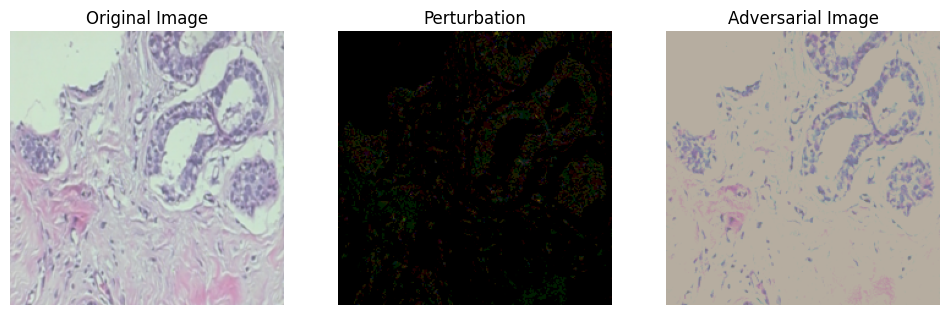

Visualizing FGSM attack effect on Teacher Model...


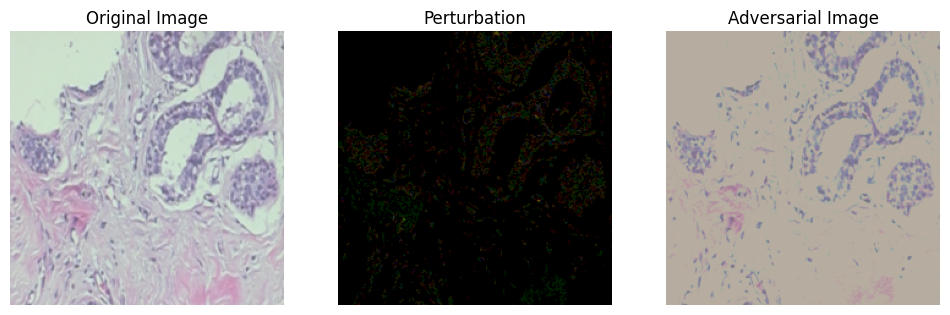

In [ ]:
def visualize_attack(model, data_loader, epsilon, model_name="Model"):
    model.eval()
    data_iter = iter(data_loader)
    data, target = next(data_iter)
    data, target = data.to(DEVICE), target.to(DEVICE)
    perturbed_data = fgsm_attack(model, data, target, epsilon)
    inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
    original_img = inv_normalize(data[0].clone().detach())
    adversarial_img = inv_normalize(perturbed_data[0].clone().detach())
    perturbation_img = (adversarial_img - original_img) * 5
    print(f"Visualizing FGSM attack effect on {model_name}...")
    plot_comparison(original_img, perturbation_img, adversarial_img)

visualize_attack(student_model, test_loader, epsilon=EPSILON, model_name="Student Model")
visualize_attack(teacher_model, test_loader, epsilon=EPSILON, model_name="Teacher Model")

In [ ]:
# Step 7: Training Functions - Adversarial Distillation + Robust Training with Early Stopping
def distillation_training(student_model, teacher_model, train_loader, val_loader, device,
                          alpha=0.7, beta=0.3, temperature=5, epsilon=0.1, epochs=50, patience=5):
    optimizer = optim.Adam(student_model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
    kl_loss_fn = nn.KLDivLoss(reduction='batchmean')
    ce_loss_fn = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        student_model.train()
        teacher_model.eval()
        total_loss = 0.0

        for inputs, targets in tqdm(train_loader, desc=f"Distillation Epoch {epoch+1}/{epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            adv_inputs = fgsm_attack(student_model, inputs.clone(), targets, epsilon)
            student_outputs = student_model(adv_inputs)
            with torch.no_grad():
                teacher_outputs = teacher_model(adv_inputs)

            soft_targets = nn.functional.softmax(teacher_outputs / temperature, dim=1)
            soft_preds = nn.functional.log_softmax(student_outputs / temperature, dim=1)
            distill_loss = kl_loss_fn(soft_preds, soft_targets) * (temperature ** 2)
            ce_loss = ce_loss_fn(student_outputs, targets)
            loss = alpha * ce_loss + beta * distill_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")

        student_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = student_model(inputs)
                loss = ce_loss_fn(outputs, targets)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(student_model.state_dict(), "/content/drive/MyDrive/Submission/best_student_model_distilled.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss (Adversarial Distillation)")
    plt.legend()
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting adversarial distillation training for student model...


Distillation Epoch 1/50: 100%|██████████| 119/119 [29:27<00:00, 14.86s/it]

Epoch 1 - Training Loss: 0.4849


Validation Loss: 0.5157


Distillation Epoch 2/50: 100%|██████████| 119/119 [00:36<00:00,  3.26it/s]

Epoch 2 - Training Loss: 0.4450


Validation Loss: 0.5682


Distillation Epoch 3/50: 100%|██████████| 119/119 [00:35<00:00,  3.33it/s]

Epoch 3 - Training Loss: 0.4412


Validation Loss: 0.5440


Distillation Epoch 4/50: 100%|██████████| 119/119 [00:35<00:00,  3.32it/s]

Epoch 4 - Training Loss: 0.4391


Validation Loss: 0.5598


Distillation Epoch 5/50: 100%|██████████| 119/119 [00:36<00:00,  3.30it/s]

Epoch 5 - Training Loss: 0.4258


Validation Loss: 0.5791


Distillation Epoch 6/50: 100%|██████████| 119/119 [00:36<00:00,  3.26it/s]

Epoch 6 - Training Loss: 0.4092


Validation Loss: 0.5795
Early stopping triggered.


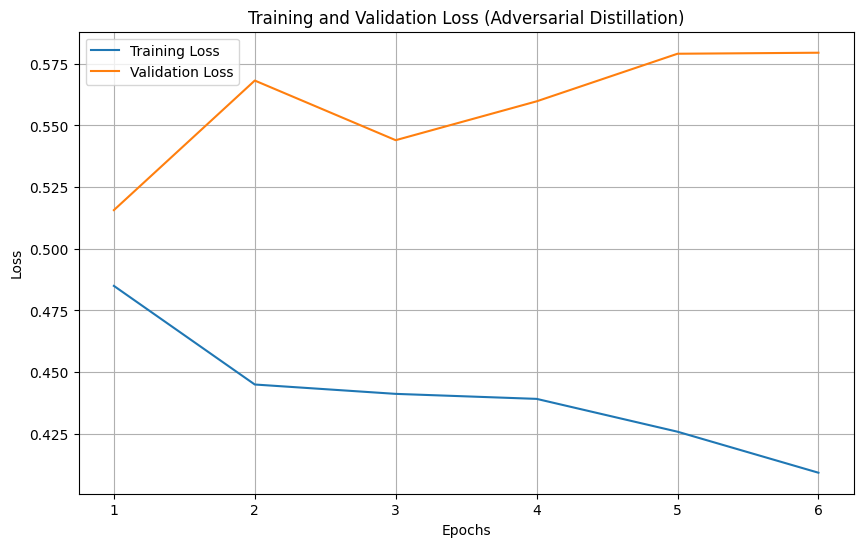

Student model saved successfully!


In [ ]:
# Step 8: Train Improved Student Model with Teacher Guidance
print("Starting adversarial distillation training for student model...")
distillation_training(student_model, teacher_model, train_loader, validation_loader, DEVICE, patience=LEARNING_RATE_PATIENCE)
print("Student model saved successfully!")

In [ ]:
# Step 9: PGD Attack
def pgd_attack(model, data, target, epsilon, alpha=0.01, iters=10):
    original = data.clone().detach()
    for _ in range(iters):
        data.requires_grad = True
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        model.zero_grad()
        loss.backward()
        data = data + alpha * data.grad.data.sign()
        eta = torch.clamp(data - original, min=-epsilon, max=epsilon)
        data = torch.clamp(original + eta, 0, 1).detach_()
    return data

In [ ]:
# Step 10: Evaluation of Distilled + Robust Student Model
def evaluate_model(model, loader, epsilon=0, attack="fgsm"):
    model.eval()
    correct, total = 0, 0
    for data, target in loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        if epsilon > 0:
            if attack == "fgsm":
                data = fgsm_attack(model, data.clone(), target, epsilon)
            elif attack == "pgd":
                data = pgd_attack(model, data.clone(), target, epsilon)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
    return 100. * correct / total